# Libraries

In [41]:
!pip install xgboost

In [73]:
!pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   -- ------------------------------------ 41.0/626.3 kB 326.8 kB/s eta 0:00:02
   -------- ----------------------------- 143.4/626.3 kB 944.1 kB/s eta 0:00:01
   ------------------- -------------------- 307.2/626.3 kB 1.6 MB/s eta 0:00:01
   ---------------------------- ----------- 440.3/626.3 kB 1.8 MB/s eta 0:00:01
   -------------------------------- ------- 501.8/626.3 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 2.0 MB/s eta 0:00:00


In [1]:
!pip install swifter

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
      --------------------------------------- 0.0/1.2 MB 330.3 kB/s eta 0:00:04
     - -------------------------------------- 0.0/1.2 MB 330.3 kB/s eta 0:00:04
     -- ------------------------------------- 0.1/1.2 MB 363.1 kB/s eta 0:00:04
     ------- -------------------------------- 0.2/1.2 MB 1.0 MB/s eta 0:00:01
     ------------ --------------------------- 0.4/1.2 MB 1.6 MB/s eta 0:00:01
     -------------------------------- ------- 1.0/1.2 MB 3.4 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16514 sha256=b49fca8466112a33a98f01bf56964816929b8f2c528d61c120ef8131ad9a4cb9
  Stored in directory: c:\users\thoma\appdata\local\

In [4]:
import pickle
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt
import swifter  # Install swifter with `pip install swifter` if not alreadyfrom sklearn.utils import resample
from os.path import exists
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier  # Import RidgeClassifier as a faster alternative
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

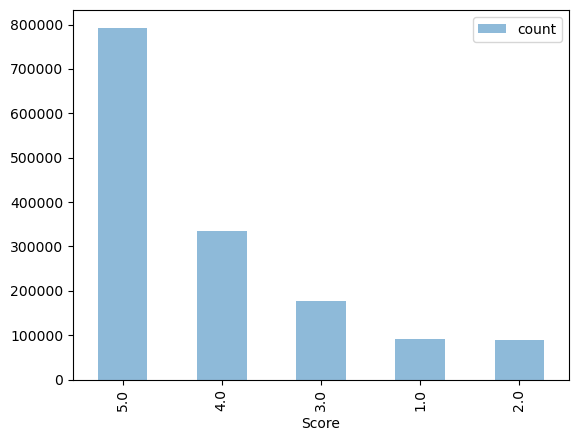


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [23]:
# Optimized feature extraction function for reduced runtime
def add_features_to(df):

    # Helpfulness calculation
    helpfulness_numerator = df.get('HelpfulnessNumerator', 0)
    helpfulness_denominator = df.get('HelpfulnessDenominator', 1)
    df['Helpfulness'] = helpfulness_numerator / helpfulness_denominator
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review age feature
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'], unit='s')
        current_time = datetime.datetime.now()
        df['ReviewAge'] = (current_time - df['Time']).dt.days

    # Check if 'Text' column exists before processing text-based features
    if 'Text' in df.columns:
        df['Text'] = df['Text'].fillna("")
        
        # Reduced TF-IDF
        tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1), stop_words='english')
        svd = TruncatedSVD(n_components=100, random_state=0)
        tfidf_matrix = tfidf.fit_transform(df['Text'])
        tfidf_reduced = svd.fit_transform(tfidf_matrix)

        # Add the SVD components as columns
        tfidf_components = pd.DataFrame(tfidf_reduced, columns=[f'text_component_{i}' for i in range(100)])
        df = pd.concat([df, tfidf_components], axis=1)

        # Polarity keyword counts (quick sentiment proxy)
        positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'positive']
        negative_words = ['bad', 'poor', 'terrible', 'hate', 'negative']
        df['PositiveCount'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in positive_words))
        df['NegativeCount'] = df['Text'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negative_words))
        df['PolarityRatio'] = (df['PositiveCount'] + 1) / (df['NegativeCount'] + 1)

        # Simple text length feature
        df['ReviewLength'] = df['Text'].apply(len)
    
    return df

# Load pre-extracted files if available
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame and generate features
    train = add_features_to(trainingSet)
    
    # Merge train features with original 'trainingSet' to retrieve the 'Score' column
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    print(train.columns)
    print(testingSet.columns)
    print(X_submission.columns)
    
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    X_train2 =  train[train['Score'].notnull()]

    # Save the processed data
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/212192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/212192 [00:00<?, ?it/s]

In [423]:
# Sample + Split into training and testing set

In [25]:
# Target a very small downsampled dataset of 5,000 rows
desired_sample_size = 5000  # Small enough for quick runtime

# Separate majority and minority classes
score_5 = X_train2[X_train2['Score'] == 5]
other_scores = X_train2[X_train2['Score'] != 5]

# Downsample score 5 proportionally to the target sample size
score_5_downsampled = resample(score_5, 
                               replace=False,  # No replacement
                               n_samples=int(desired_sample_size * 0.5),  # 50% of sample size
                               random_state=0)

# Downsample other scores to collectively make up the remaining 50%
other_scores_downsampled = resample(other_scores, 
                                    replace=False,
                                    n_samples=int(desired_sample_size * 0.5),
                                    random_state=0)

# Combine to create a balanced subset of data
balanced_data = pd.concat([score_5_downsampled, other_scores_downsampled]).dropna(subset=['Score'])

# Separate features and target (Score) before feature extraction
y = (balanced_data['Score'] - 1).astype(int)  # Convert target variable to integer
balanced_data = balanced_data.drop(columns=['Score'])  # Drop 'Score' column for feature extraction

#THIS IS FOR SUBMISSION 2
#y = balanced_data['Score']  # Target variable
#balanced_data = balanced_data.drop(columns=['Score'])  # Drop 'Score' column for feature extraction

# Apply the feature extraction function to `balanced_data`
X = balanced_data

# Train-test split with stratification to maintain balanced classes
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    y,
    test_size=0.25,  # 75% training and 25% testing
    random_state=0,
    stratify=y
)

# Feature Selection

In [2]:
# Check available columns after feature extraction
#features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']
#solutions 2 3 and 4
#features = [
#    'Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'ReviewAge',
#    'PositiveCount', 'NegativeCount', 'PolarityRatio', 'ReviewLength'
#] + [f'text_component_{i}' for i in range(100)]


#features = ['Helpfulness', 'ReviewAge', 'Polarity', 'Subjectivity', 'PolarityRatio', 'ReviewLength'] + \
#           [f'text_component_{i}' for i in range(100)]
#Solution 2 and 3
# Selected features
features = ['Helpfulness', 'ReviewAge', 'PositiveCount', 'NegativeCount', 'PolarityRatio', 'ReviewLength'] + [f'text_component_{i}' for i in range(100)]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


NameError: name 'X_train' is not defined

# Model Creation

In [ ]:
# Define parameter grids for RandomizedSearchCV
param_grids = {
    'xgb': {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
    },
    'rf': {
        'n_estimators': randint(100, 300),
        'max_depth': randint(5, 15),
        'max_features': ['sqrt', 'log2'],  # Updated to only include 'sqrt' and 'log2'
    },
    'svc': {
        'C': uniform(0.5, 2),
        'gamma': ['scale', 'auto'],
    },
    'gbc': {
        'n_estimators': randint(100, 250),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 7),
    }
}


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)

# Filenames for saving the scaler and ensemble model
scaler_filename = "./models/scaler.pkl"
ensemble_model_filename = "./models/stacked_ensemble_model.pkl"  # Update here

# Check if scaler and model already exist to load them
if exists(scaler_filename) and exists(ensemble_model_filename):
    # Load the scaler and ensemble model
    with open(scaler_filename, 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)
    with open(ensemble_model_filename, 'rb') as model_file:
        stacked_ensemble = pickle.load(model_file)  # Updated to load into stacked_ensemble
    print("Loaded existing scaler and ensemble model.")
else:
    # Define individual models with updated parameters
    xgb = XGBClassifier(random_state=0)
    rf = RandomForestClassifier(random_state=0)
    svc = SVC(probability=True, random_state=0)
    gbc = GradientBoostingClassifier(random_state=0)

    def tune_model(model, param_grid):
        random_search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=3, random_state=0, n_jobs=-1)
        random_search.fit(X_train_scaled, Y_train)
        print(f"Best parameters for {model.__class__.__name__}: {random_search.best_params_}")
        return random_search.best_estimator_

    xgb = tune_model(xgb, param_grids['xgb'])
    rf = tune_model(rf, param_grids['rf'])
    svc = tune_model(svc, param_grids['svc'])
    gbc = tune_model(gbc, param_grids['gbc'])

    # Expanded ensemble with SVC and Gradient Boosting
    stacked_ensemble = StackingClassifier(
        estimators=[('xgb', xgb), ('rf', rf), ('svc', svc), ('gbc', gbc)],
        final_estimator=LogisticRegression(random_state=0)
    )

    # Train the stacked ensemble with cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(stacked_ensemble, X_train_scaled, Y_train, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean()}")

    # Train the ensemble model
    stacked_ensemble.fit(X_train_scaled, Y_train)
    
    # Ensure the models directory exists
    os.makedirs('./models', exist_ok=True)

    with open(ensemble_model_filename, 'wb') as model_file:
        pickle.dump(stacked_ensemble, model_file)

# Predict and evaluate on the test set
Y_test_predictions = stacked_ensemble.predict(X_test_scaled)
print("Stacked Ensemble Model Accuracy on Testing Set:", accuracy_score(Y_test, Y_test_predictions))


Best parameters for XGBClassifier: {'learning_rate': 0.09089844418701698, 'max_depth': 4, 'n_estimators': 138}
Best parameters for RandomForestClassifier: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}
Best parameters for SVC: {'C': 1.435482199008357, 'gamma': 'scale'}
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}


# Model Evaluation

Accuracy on testing set =  0.4596


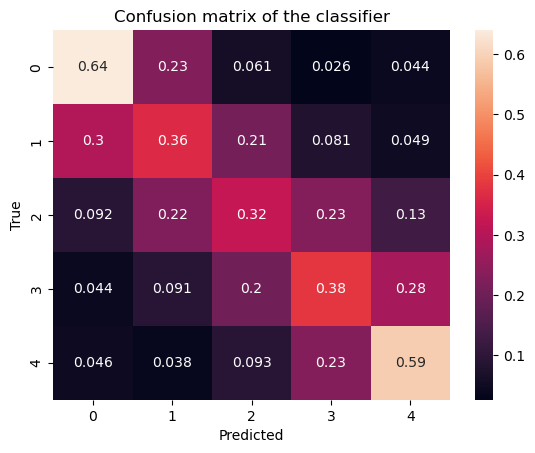

In [449]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [ ]:
# Create the submission file

X_submission['Score'] = stacked_ensemble.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)